### Spatial Understanding with Qwen3-VL

This notebook showcases Qwen3-VL's advanced spatial localization abilities, including accurate object detection, specific target grounding within images.

First of all, we list the major updates of Qwen3-VL's spatial understanding abilities as follows:
* Coordinate System: Qwen3-VL's default coordinate system has been changed from the absolute coordinates used in Qwen2.5-VL to relative coordinates ranging from 0 to 1000. (You don't need to calculate the resized_w)
* Multi-Target Grounding: Qwen3-VL has improved its multi-target grounding ability.

Now, Let's see how it integrates visual and linguistic understanding to interpret complex scenes effectively.

#### \[Setup\]
* step1: Prepare the environment

In [46]:
# !pip install git+https://github.com/huggingface/transformers
# !pip install qwen-vl-utils
# !pip install openai
# pip install qwen-vl-utils
# pip install openai

* step2: Load visualization utils.

In [47]:
# @title Plotting Util

# Get Noto JP font to display janapese characters
!apt-get install fonts-noto-cjk  # For Noto Sans CJK JP

#!apt-get install fonts-source-han-sans-jp # For Source Han Sans (Japanese)

import ast
import json
from io import BytesIO

from PIL import Image, ImageColor, ImageDraw, ImageFont

additional_colors = [
    colorname for (colorname, colorcode) in ImageColor.colormap.items()
]


def decode_json_points(text: str):
    """Parse coordinate points from text format"""
    try:
        # 清理markdown标记
        if "```json" in text:
            text = text.split("```json")[1].split("```")[0]

        # 解析JSON
        data = json.loads(text)
        points = []
        labels = []

        for item in data:
            if "point_2d" in item:
                x, y = item["point_2d"]
                points.append([x, y])

                # 获取label，如果没有则使用默认值
                label = item.get("label", f"point_{len(points)}")
                labels.append(label)

        return points, labels

    except Exception as e:
        print(f"Error: {e}")
        return [], []


def plot_bounding_boxes(im, bounding_boxes):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
        "red",
        "green",
        "blue",
        "yellow",
        "orange",
        "pink",
        "purple",
        "brown",
        "gray",
        "beige",
        "turquoise",
        "cyan",
        "magenta",
        "lime",
        "navy",
        "maroon",
        "teal",
        "olive",
        "coral",
        "lavender",
        "violet",
        "gold",
        "silver",
    ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

    try:
        json_output = ast.literal_eval(bounding_boxes)
    except Exception:
        end_idx = bounding_boxes.rfind('"}') + len('"}')
        truncated_text = bounding_boxes[:end_idx] + "]"
        json_output = ast.literal_eval(truncated_text)

    if not isinstance(json_output, list):
        json_output = [json_output]

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json_output):
        # Select a color from the list
        color = colors[i % len(colors)]

        # Convert normalized coordinates to absolute coordinates
        abs_y1 = int(bounding_box["bbox_2d"][1] / 1000 * height)
        abs_x1 = int(bounding_box["bbox_2d"][0] / 1000 * width)
        abs_y2 = int(bounding_box["bbox_2d"][3] / 1000 * height)
        abs_x2 = int(bounding_box["bbox_2d"][2] / 1000 * width)

        if abs_x1 > abs_x2:
            abs_x1, abs_x2 = abs_x2, abs_x1

        if abs_y1 > abs_y2:
            abs_y1, abs_y2 = abs_y2, abs_y1

        # Draw the bounding box
        draw.rectangle(((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=3)

        # Draw the text
        if "label" in bounding_box:
            draw.text(
                (abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font
            )

    # Display the image
    img.show()


def plot_points(im, text):
    img = im
    width, height = img.size
    draw = ImageDraw.Draw(img)
    colors = [
        "red",
        "green",
        "blue",
        "yellow",
        "orange",
        "pink",
        "purple",
        "brown",
        "gray",
        "beige",
        "turquoise",
        "cyan",
        "magenta",
        "lime",
        "navy",
        "maroon",
        "teal",
        "olive",
        "coral",
        "lavender",
        "violet",
        "gold",
        "silver",
    ] + additional_colors

    points, descriptions = decode_json_points(text)
    print("Parsed points: ", points)
    print("Parsed descriptions: ", descriptions)
    if points is None or len(points) == 0:
        img.show()
        return

    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

    for i, point in enumerate(points):
        color = colors[i % len(colors)]
        abs_x1 = int(point[0]) / 1000 * width
        abs_y1 = int(point[1]) / 1000 * height
        radius = 2
        draw.ellipse(
            [(abs_x1 - radius, abs_y1 - radius), (abs_x1 + radius, abs_y1 + radius)],
            fill=color,
        )
        draw.text((abs_x1 - 20, abs_y1 + 6), descriptions[i], fill=color, font=font)

    img.show()


def plot_points_json(im, text):
    img = im
    width, height = img.size
    draw = ImageDraw.Draw(img)
    colors = [
        "red",
        "green",
        "blue",
        "yellow",
        "orange",
        "pink",
        "purple",
        "brown",
        "gray",
        "beige",
        "turquoise",
        "cyan",
        "magenta",
        "lime",
        "navy",
        "maroon",
        "teal",
        "olive",
        "coral",
        "lavender",
        "violet",
        "gold",
        "silver",
    ] + additional_colors
    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

    text = text.replace("```json", "")
    text = text.replace("```", "")
    data = json.loads(text)
    for item in data:
        point_2d = item["point_2d"]
        label = item["label"]
        x, y = int(point_2d[0] / 1000 * width), int(point_2d[1] / 1000 * height)
        radius = 2
        draw.ellipse(
            [(x - radius, y - radius), (x + radius, y + radius)], fill=colors[0]
        )
        draw.text((x + 2 * radius, y + 2 * radius), label, fill=colors[0], font=font)

    img.show()


# @title Parsing JSON output
def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(
                lines[i + 1 :]
            )  # Remove everything before "```json"
            json_output = json_output.split("```")[
                0
            ]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

正在读取软件包列表... 完成%
正在分析软件包的依赖关系树... 完成%
正在读取状态信息... 完成                   
fonts-noto-cjk 已经是最新版 (1:20220127+repack1-1)。
升级了 0 个软件包，新安装了 0 个软件包， 要卸载 0 个软件包，有 164 个软件包未被升级。


* step3: Prepare utils for Dashscope API call.

In [ ]:
import copy
import os
import time
import traceback

import requests
from openai import OpenAI

## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
os.environ["DASHSCOPE_API_KEY"] = "your_api_key_here"

DASHSCOPE_API_KEY = os.environ.get("DASHSCOPE_API_KEY", "empty")

CALL_URL = "https://dashscope-intl.aliyuncs.com/compatible-mode/v1"
HEADERS = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {DASHSCOPE_API_KEY}",
}


def dash_call(**kwargs):
    payload = copy.deepcopy(kwargs)
    assert "model" in payload
    max_try = 10
    for i in range(max_try):
        try:
            ret = requests.post(CALL_URL, json=payload, headers=HEADERS, timeout=180)
            if ret.status_code != 200:
                raise Exception(f"http status_code: {ret.status_code}\n{ret.content}")
            ret_json = ret.json()
            gen_content = (
                ret_json.get("output", {})
                .get("choices", [{}])[0]
                .get("message", {})
                .get("content", "")
            )
            result = "".join(
                output.get("text", "") for output in gen_content if "text" in output
            )
            return result
        except Exception:
            print(traceback.format_exc())
            time.sleep(10)
    raise Exception("Max Retry!!!")


def inference_with_dashscope_api(
    img_url, prompt, min_pixels=64 * 32 * 32, max_pixels=9800 * 32 * 32
):
    messages = [
        {
            "role": "user",
            "content": [
                {
                    # You can set the min_pixels and max_pixels to control the size of the image according to your use case.
                    "image": img_url,
                    "min_pixels": min_pixels,
                    "max_pixels": max_pixels,
                },
                {"type": "text", "text": prompt},
            ],
        }
    ]
    kwargs = dict(model="qwen3-vl-235b-a22b-instruct", input={"messages": messages})
    try:
        model_response = dash_call(**kwargs)
    except Exception as e:
        print(e)
        return None
    return model_response


def inference_with_openai_api(
    img_url, prompt, min_pixels=64 * 32 * 32, max_pixels=9800 * 32 * 32
):
    import base64
    import os

    if os.path.exists(img_url):
        with open(img_url, "rb") as image_file:
            base64_image = base64.b64encode(image_file.read()).decode("utf-8")
    elif img_url.startswith("http://") or img_url.startswith("https://"):
        response = requests.get(img_url)
        response.raise_for_status()
        base64_image = base64.b64encode(response.content).decode("utf-8")
    else:
        raise ValueError("Invalid image URL")
    client = OpenAI(
        api_key=os.getenv("DASHSCOPE_API_KEY"),
        base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
    )
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                    "min_pixels": min_pixels,
                    "max_pixels": max_pixels,
                },
                {"type": "text", "text": prompt},
            ],
        }
    ]
    completion = client.chat.completions.create(
        model="qwen3-vl-235b-a22b-instruct",  # 可按需更换模型名称。模型列表：https://help.aliyun.com/zh/model-studio/models
        messages=messages,
    )
    return completion.choices[0].message.content

#### 1. Multi-Target Object Detection
Let's start with the newly-updated multi-target grounding ability.

```json
[
	{"bbox_2d": [74, 361, 324, 808], "label": "plate/dish"},
	{"bbox_2d": [320, 660, 564, 956], "label": "plate/dish"},
	{"bbox_2d": [555, 575, 807, 901], "label": "plate/dish"},
	{"bbox_2d": [484, 187, 743, 568], "label": "plate/dish"},
	{"bbox_2d": [739, 440, 999, 901], "label": "plate/dish"},
	{"bbox_2d": [300, 134, 481, 397], "label": "plate/dish"},
	{"bbox_2d": [691, 235, 775, 328], "label": "scallop"},
	{"bbox_2d": [752, 204, 856, 325], "label": "scallop"},
	{"bbox_2d": [835, 200, 919, 312], "label": "scallop"},
	{"bbox_2d": [735, 328, 834, 443], "label": "scallop"},
	{"bbox_2d": [812, 308, 918, 443], "label": "scallop"},
	{"bbox_2d": [885, 300, 980, 429], "label": "scallop"},
	{"bbox_2d": [162, 0, 303, 354], "label": "wine bottle"},
	{"bbox_2d": [462, 0, 589, 210], "label": "wine bottle"},
	{"bbox_2d": [615, 72, 730, 212], "label": "bowl"},
	{"bbox_2d": [255, 82, 333, 220], "label": "bowl"},
	{"bbox_2d": [0, 801, 102, 999], "label": "bowl"},
	{"bbox_2d": [619, 939, 762, 9

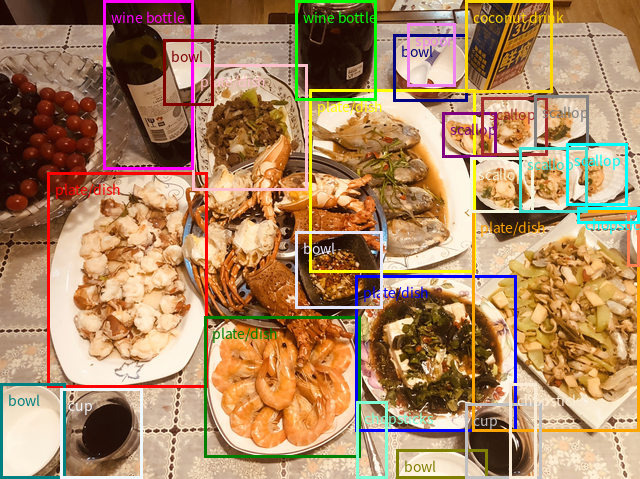

In [ ]:
# Example 1: Detecting different objects on a dining table

# You can specify the categories of the instances you want to locate (negative categories are also supported and will be skipped during generation)
prompt = 'locate every instance that belongs to the following categories: "plate/dish, scallop, wine bottle, tv, bowl, spoon, air conditioner, coconut drink, cup, chopsticks, person". Report bbox coordinates in JSON format.'
img_url = "./assets/spatial_understanding/dining_table.png"
model_response = inference_with_openai_api(img_url, prompt)
print(model_response)

response = requests.get(img_url)
response.raise_for_status()
image = Image.open(BytesIO(response.content))

image.thumbnail([640, 640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image, model_response)

```json
[
	{"bbox_2d": [37, 661, 165, 817], "label": "head"},
	{"bbox_2d": [241, 666, 380, 852], "label": "head"},
	{"bbox_2d": [448, 782, 566, 971], "label": "head"},
	{"bbox_2d": [658, 684, 760, 825], "label": "head"},
	{"bbox_2d": [833, 700, 955, 850], "label": "head"},
	{"bbox_2d": [890, 515, 992, 643], "label": "head"},
	{"bbox_2d": [670, 503, 764, 628], "label": "head"},
	{"bbox_2d": [473, 573, 570, 717], "label": "head"},
	{"bbox_2d": [374, 478, 464, 603], "label": "head"},
	{"bbox_2d": [186, 494, 273, 615], "label": "head"},
	{"bbox_2d": [38, 470, 131, 592], "label": "head"},
	{"bbox_2d": [723, 353, 807, 465], "label": "head"},
	{"bbox_2d": [920, 385, 999, 490], "label": "head"},
	{"bbox_2d": [840, 244, 918, 339], "label": "head"},
	{"bbox_2d": [656, 235, 735, 341], "label": "head"},
	{"bbox_2d": [550, 297, 628, 400], "label": "head"},
	{"bbox_2d": [458, 377, 544, 494], "label": "head"},
	{"bbox_2d": [390, 254, 475, 378], "label": "head"},
	{"bbox_2d": [269, 330, 356, 457], "la

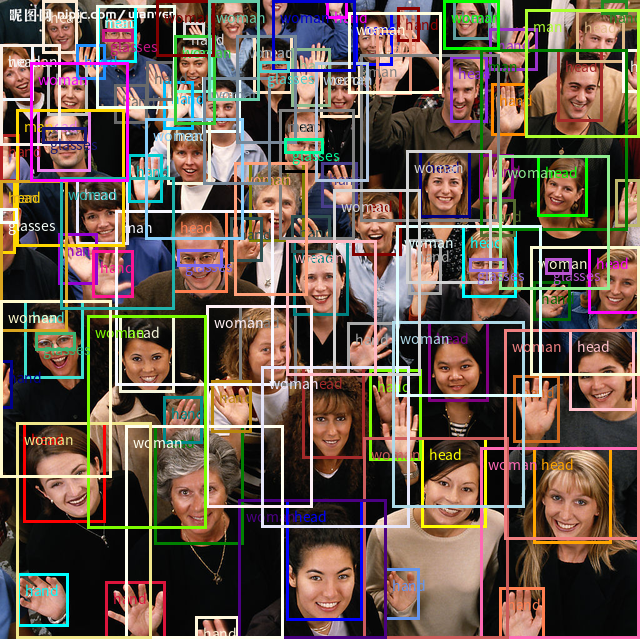

In [ ]:
# Example 2: Detecting different objects in crowded scenes

# You can specify the categories of the instances you want to locate (negative categories are also supported and will be skipped during generation)
prompt = 'Locate every instance that belongs to the following categories: "head, hand, man, woman, glasses". Report bbox coordinates in JSON format.'
img_url = "./assets/spatial_understanding/lots_of_people.jpeg"
model_response = inference_with_openai_api(img_url, prompt)
print(model_response)

response = requests.get(img_url)
response.raise_for_status()
image = Image.open(BytesIO(response.content))

image.thumbnail([640, 640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image, model_response)

```json
[
	{"bbox_2d": [573, 190, 596, 272], "label": "car"},
	{"bbox_2d": [611, 274, 631, 354], "label": "car"},
	{"bbox_2d": [637, 323, 661, 402], "label": "car"},
	{"bbox_2d": [577, 365, 599, 445], "label": "car"},
	{"bbox_2d": [616, 493, 637, 577], "label": "car"},
	{"bbox_2d": [643, 531, 667, 623], "label": "car"},
	{"bbox_2d": [581, 544, 603, 617], "label": "car"},
	{"bbox_2d": [613, 652, 634, 736], "label": "car"},
	{"bbox_2d": [648, 725, 671, 807], "label": "car"},
	{"bbox_2d": [577, 776, 600, 858], "label": "car"},
	{"bbox_2d": [556, 920, 579, 999], "label": "car"},
	{"bbox_2d": [592, 935, 615, 999], "label": "car"},
	{"bbox_2d": [621, 916, 643, 999], "label": "car"},
	{"bbox_2d": [655, 962, 676, 999], "label": "car"},
	{"bbox_2d": [706, 109, 742, 175], "label": "car"},
	{"bbox_2d": [764, 190, 807, 236], "label": "car"},
	{"bbox_2d": [762, 296, 807, 336], "label": "car"},
	{"bbox_2d": [768, 347, 811, 384], "label": "car"},
	{"bbox_2d": [790, 382, 834, 420], "label": "car"},
	{

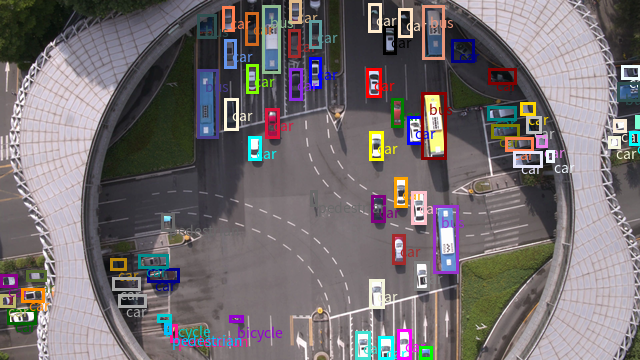

In [ ]:
# Example 3: Detecting different objects in a 4K drone-view image

# You can specify the categories of the instances you want to locate (negative categories are also supported and will be skipped during generation)
prompt = 'Locate every instance that belongs to the following categories: "car, bus, bicycle, pedestrian". Report bbox coordinates in JSON format.'
img_url = "./assets/spatial_understanding/lots_of_cars.png"
model_response = inference_with_openai_api(img_url, prompt)
print(model_response)

response = requests.get(img_url)
response.raise_for_status()
image = Image.open(BytesIO(response.content))

image.thumbnail([640, 640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image, model_response)

In addition, you can specify more complex requirements in grounding tasks by defining the output format, such as including additional key information like object attributes, descriptions, etc.

```json
[
	{"bbox_2d": [355, 425, 381, 480], "label": "vehicle", "type": "car", "color": "white"},
	{"bbox_2d": [412, 355, 437, 405], "label": "vehicle", "type": "car", "color": "white"},
	{"bbox_2d": [428, 231, 450, 280], "label": "vehicle", "type": "car", "color": "white"},
	{"bbox_2d": [496, 3, 509, 27], "label": "vehicle", "type": "car", "color": "white"},
	{"bbox_2d": [539, 0, 552, 17], "label": "vehicle", "type": "car", "color": "black"},
	{"bbox_2d": [556, 0, 568, 15], "label": "vehicle", "type": "car", "color": "white"},
	{"bbox_2d": [555, 39, 568, 63], "label": "vehicle", "type": "car", "color": "black"},
	{"bbox_2d": [539, 63, 553, 85], "label": "vehicle", "type": "car", "color": "black"},
	{"bbox_2d": [537, 103, 552, 129], "label": "vehicle", "type": "car", "color": "white"},
	{"bbox_2d": [557, 89, 572, 113], "label": "vehicle", "type": "car", "color": "white"},
	{"bbox_2d": [597, 83, 611, 109], "label": "vehicle", "type": "car", "color": "white"},
	{"bbox_2d": [600, 47, 613

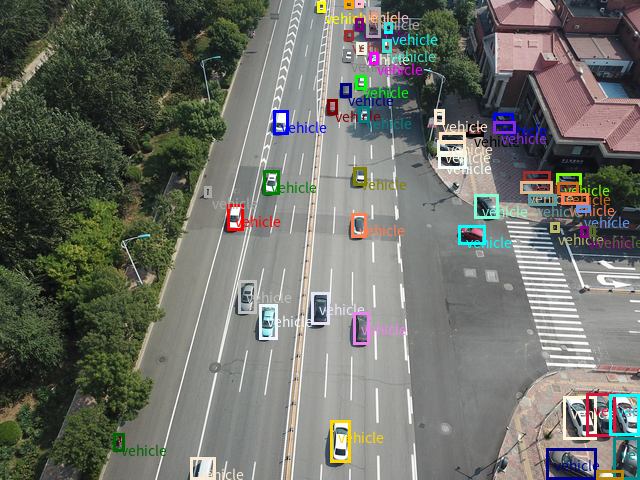

In [ ]:
# Example 4: Detecting vehicles with additional key information

# You can set the output format to include additional key information like object attributes, descriptions, etc.
prompt = 'locate every instance that belongs to the following categories: "vehicle". For each vehicle, report bbox coordinates, vehicle type and vehicle color in JSON format like this: {"bbox_2d": [x1, y1, x2, y2], "label": "vehicle", "type": "car, bus, truck, bicycle, ...", "color": "vehicle_color"}'
img_url = "./assets/spatial_understanding/drone_cars2.png"
model_response = inference_with_openai_api(img_url, prompt)
print(model_response)

response = requests.get(img_url)
response.raise_for_status()
image = Image.open(BytesIO(response.content))

image.thumbnail([640, 640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image, model_response)

Similarly, point-based grounding also supports the above feature.

```json
[
	{"point_2d": [346, 328], "label": "person", "role": "referee", "shirt_color": "black"},
	{"point_2d": [238, 158], "label": "person", "role": "player", "shirt_color": "red"},
	{"point_2d": [244, 158], "label": "person", "role": "player", "shirt_color": "white"},
	{"point_2d": [335, 257], "label": "person", "role": "player", "shirt_color": "red"},
	{"point_2d": [294, 295], "label": "person", "role": "player", "shirt_color": "white"},
	{"point_2d": [170, 350], "label": "person", "role": "player", "shirt_color": "white"},
	{"point_2d": [152, 361], "label": "person", "role": "player", "shirt_color": "red"},
	{"point_2d": [178, 289], "label": "person", "role": "player", "shirt_color": "red"},
	{"point_2d": [434, 145], "label": "person", "role": "player", "shirt_color": "red"},
	{"point_2d": [444, 132], "label": "person", "role": "player", "shirt_color": "white"},
	{"point_2d": [526, 231], "label": "person", "role": "player", "shirt_color": "white"},
	{"point_2d": [527, 254], "labe

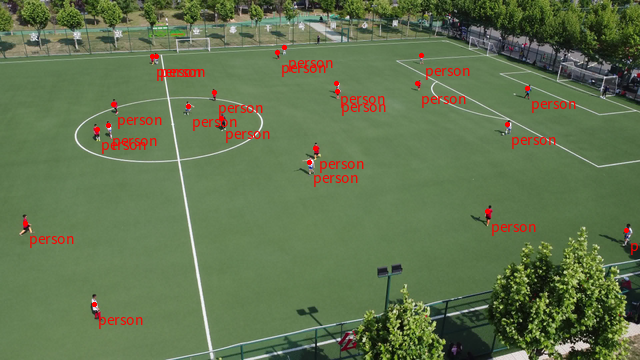

In [ ]:
# Example 5: Pointing out the people inside a football field and output their role and shirt color.

# You can also set the output format to include additional key information like object attributes, descriptions, etc in point-based grounding.
prompt = """Locate every person inside the football field with points, report their point coordinates, role(player, referee or unknown) and shirt color in JSON format like this: {"point_2d": [x, y], "label": "person", "role": "player/referee/unknown", "shirt_color": "the person's shirt color"}"""
img_url = "./assets/spatial_understanding/football_field.jpg"
model_response = inference_with_openai_api(img_url, prompt)
print(model_response)

response = requests.get(img_url)
response.raise_for_status()
image = Image.open(BytesIO(response.content))

image.thumbnail([640, 640], Image.Resampling.LANCZOS)
plot_points_json(image, model_response)

#### 2. Detect certain object in the image

Furthermore, based on this capability, we can prompt the model with specific questions that require spatial reasoning, such as "Is object A above or below object B?" or "Please describe the object closest to object C."

```json
[
	{"bbox_2d": [134, 746, 308, 925], "label": "small cake"},
	{"bbox_2d": [350, 658, 517, 821], "label": "small cake"},
	{"bbox_2d": [510, 560, 666, 714], "label": "small cake"},
	{"bbox_2d": [295, 547, 445, 707], "label": "small cake"},
	{"bbox_2d": [42, 556, 200, 729], "label": "small cake"},
	{"bbox_2d": [67, 392, 206, 573], "label": "small cake"},
	{"bbox_2d": [249, 376, 370, 540], "label": "small cake"},
	{"bbox_2d": [400, 371, 506, 504], "label": "small cake"},
	{"bbox_2d": [433, 443, 566, 600], "label": "small cake"},
	{"bbox_2d": [531, 355, 654, 524], "label": "small cake"},
	{"bbox_2d": [629, 476, 771, 638], "label": "small cake"},
	{"bbox_2d": [800, 511, 959, 691], "label": "small cake"},
	{"bbox_2d": [738, 379, 865, 538], "label": "small cake"}
]
```
(1024, 1024)
(640, 640)


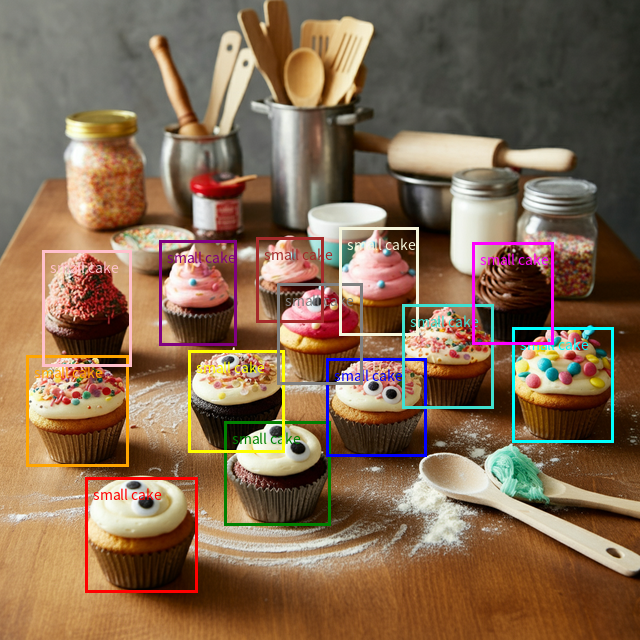

In [54]:
image_path = "./assets/spatial_understanding/spatio_case1.jpg"
prompt = "Which object, in relation to your current position, holds the farthest placement in the image?\nAnswer options:\nA.chair\nB.plant\nC.window\nD.tv stand."
response = inference_with_api(image_path, prompt)

# prompt in chinese
prompt = "框出每一个小蛋糕的位置，以json格式输出所有的坐标"
# prompt in english
prompt = "Outline the position of each small cake and output all the coordinates in JSON format."

## Use openai-style api to inference.
model_response = inference_with_openai_api(image_path, prompt)
print(model_response)

image = Image.open(image_path)
print(image.size)
image.thumbnail([640, 640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image, model_response)

Further, you can search for a specific object by using a short phrase or sentence to describe it.

```json
[
	{"bbox_2d": [739, 377, 865, 535], "label": "top right brown cake"}
]
```
(640, 640)


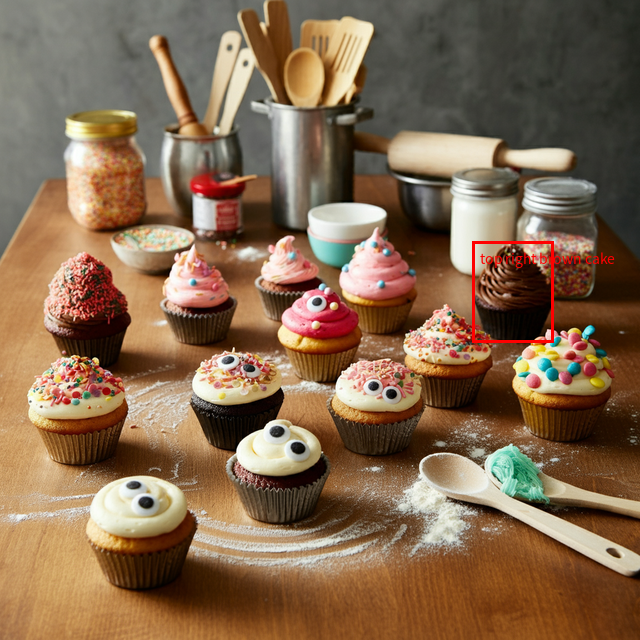

In [55]:
image_path = "./assets/spatial_understanding/cakes.png"

# prompt in chinses
prompt = "定位最右上角的棕色蛋糕，以JSON格式输出其bbox坐标"
# prompt in english
prompt = (
    "Locate the top right brown cake, output its bbox coordinates using JSON format."
)

## Use openai-style api to inference.
model_response = inference_with_openai_api(image_path, prompt)
print(model_response)

image = Image.open(image_path)
image.thumbnail([640, 640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image, model_response)

For spatial pointing tasks, Qwen3-VL now support these formats:

In addition to the above mentioned bbox format [x1, y1, x2, y2], Qwen2.5-VL also supports point-based grounding. You can point to a specific object and the model is trained to output xml-style results.

<points x1="707" y1="233" alt="rolling pin on the far side of the table">rolling pin on the far side of the table</points>


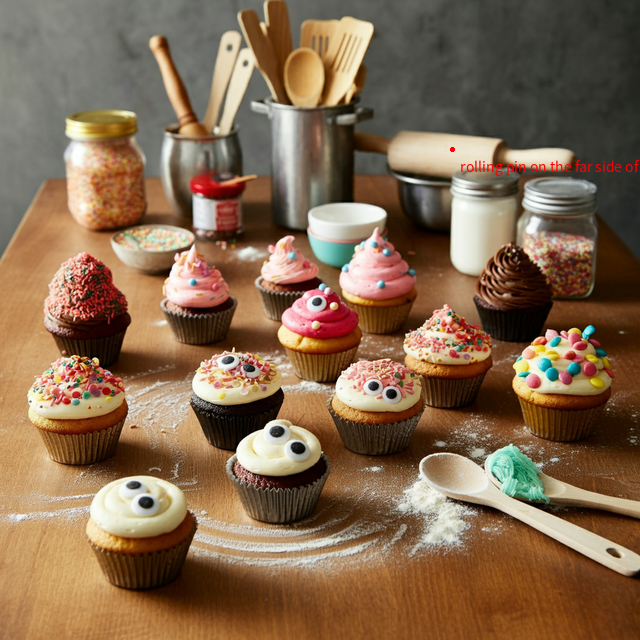

In [56]:
image_path = "./assets/spatial_understanding/cakes.png"

# prompt in chinese
prompt = "以点的形式定位图中桌子远处的擀面杖，以XML格式输出其坐标"
# prompt in english
prompt = "point to the rolling pin on the far side of the table, output its coordinates in XML format <points x y>object</points>"

## Use openai-style api to inference.
model_response = inference_with_openai_api(image_path, prompt)
print(model_response)

image = Image.open(image_path)
image.thumbnail([640, 640], Image.Resampling.LANCZOS)
plot_points(image, model_response)

```json
[
	{"bbox_2d": [255, 430, 435, 611], "label": "shadow of the paper fox"}
]
```
Parsed points:  [[925, 618]]
Parsed descriptions:  ['point_1']


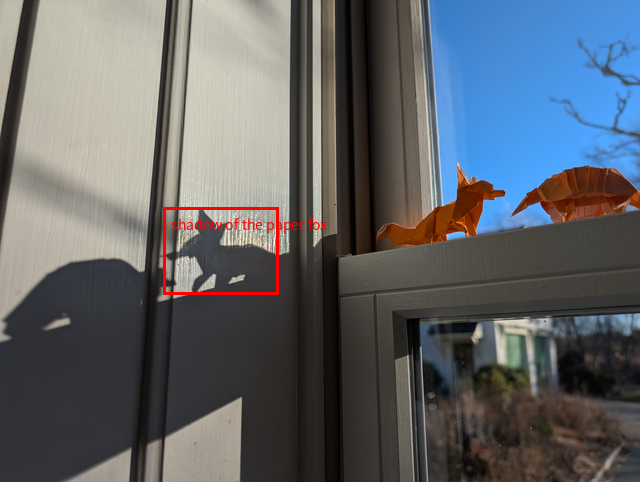

In [57]:
image_path = "./assets/spatial_understanding/spatio_case2_aff.png"
prompt = "Locate the free space on the white table on the right in this image. Output the point coordinates in JSON format."
response = inference_with_api(image_path, prompt)

# prompt in chinese
prompt = "框出图中纸狐狸的影子，以json格式输出其bbox坐标"
# prompt in english
prompt = (
    "Locate the shadow of the paper fox, report the bbox coordinates in JSON format."
)

## Use openai-style api to inference.
model_response = inference_with_openai_api(image_path, prompt)
print(model_response)

image = Image.open(image_path)
image.thumbnail([640, 640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image, model_response)

```json
[
	{"bbox_2d": [69, 91, 458, 967], "label": "person who act bravely"}
]
```
(640, 360)


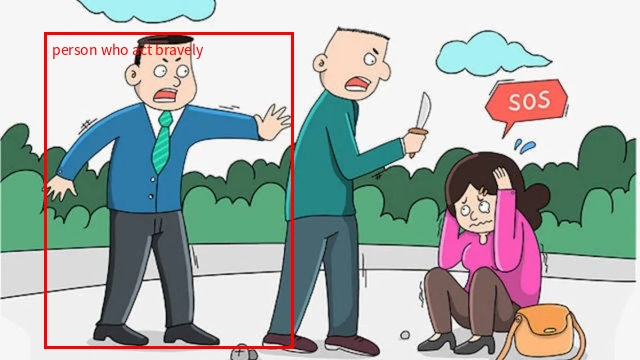

In [58]:
image_path = "./assets/spatial_understanding/spatio_case2_aff2.png"
prompt = "Can the speaker fit behind the guitar?"
response = inference_with_api(image_path, prompt)

# prompt in chinese
prompt = "框出图中见义勇为的人，以json格式输出其bbox坐标"
# prompt in english
prompt = (
    "Locate the person who act bravely, report the bbox coordinates in JSON format."
)

## Use openai-style api to inference.
model_response = inference_with_openai_api(image_path, prompt)
print(model_response)

image = Image.open(image_path)
image.thumbnail([640, 640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image, model_response)

#### 3. Integrate Spatial Reasoning and Action Planning

This advanced task integrates the understanding of spatial relationships and affordances. The model must synthesize these capabilities to select the correct action that achieves a goal, effectively reasoning like an embodied agent.

{
  "bbox_2d": [225, 375, 475, 625], "label": "sunglasses"
}
(640, 465)


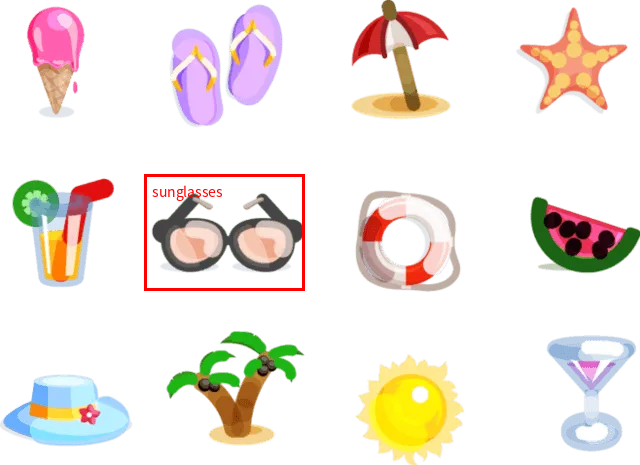

In [59]:
image_path = "./assets/spatial_understanding/spatio_case2_plan.png"
prompt = "What color arrow should the robot follow to move the apple in between the green can and the orange? Choices: A. Red. B. Blue. C. Green. D. Orange."
response = inference_with_api(image_path, prompt)

# prompt in chinese
prompt = "如果太阳很刺眼，我应该用这张图中的什么物品，框出该物品在图中的bbox坐标，并以json格式输出"
# prompt in english
prompt = "If the sun is very glaring, which item in this image should I use? Please locate it in the image with its bbox coordinates and its label and output in JSON format."

## Use openai-style api to inference.
model_response = inference_with_openai_api(url, prompt)
print(model_response)

image = Image.open(url)
image.thumbnail([640, 640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image, model_response)

#### 7. Known Limitations
* When the number of instances in a particular category significantly exceeds 40-50 or when objects are densely packed, the model may enter an endless generation loop.
* The model occasionally detects a cluster of closely spaced objects as a single bounding box. This issue can be mitigated by refining the input prompt.

#### 8. spatial understanding with designed system prompt
The above usage is based on the default system prompt. You can also change the system prompt to obtain other output format like plain text.
Qwen3-VL now support these formats:
* bbox-format: JSON (default)

from IPython.display import Markdown, display
import numpy as np
from PIL import Image
import decord
from decord import VideoReader, cpu


def download_video(url, dest_path):
    response = requests.get(url, stream=True)
    with open(dest_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8096):
            f.write(chunk)
    print(f"Video downloaded to {dest_path}")


def get_video_frames(video_path, num_frames=128, cache_dir='./assets/spatial_understanding/'):
    os.makedirs(cache_dir, exist_ok=True)

* point-format: JSON (default)

    frames_cache_file = os.path.join(cache_dir, f'{video_hash}_{num_frames}_frames.npy')
    timestamps_cache_file = os.path.join(cache_dir, f'{video_hash}_{num_frames}_timestamps.npy')

    if os.path.exists(frames_cache_file) and os.path.exists(timestamps_cache_file):
        frames = np.load(frames_cache_file)
        timestamps = np.load(timestamps_cache_file)
        return video_file_path, frames, timestamps

    vr = VideoReader(video_file_path, ctx=cpu(0))
    total_frames = len(vr)

    indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)
    frames = vr.get_batch(indices).asnumpy()
    timestamps = np.array([vr.get_frame_timestamp(idx) for idx in indices])

    np.save(frames_cache_file, frames)
    np.save(timestamps_cache_file, timestamps)
    
    return video_file_path, frames, timestamps


def create_image_grid(images, num_columns=8):
    pil_images = [Image.fromarray(image) for image in images]
    num_rows = math.ceil(len(images) / num_columns)

    img_width, img_height = pil_images[0].size
    grid_width = num_columns * img_width
    grid_height = num_rows * img_height
    grid_image = Image.new('RGB', (grid_width, grid_height))

    for idx, image in enumerate(pil_images):
        row_idx = idx // num_columns
        col_idx = idx % num_columns
        position = (col_idx * img_width, row_idx * img_height)
        grid_image.paste(image, position)

    return grid_image
